In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio
import pandas as pd

nest_asyncio.apply()  #
EXPERIMENT_NAME = "shea_cross_testing4"

In [2]:
import torch

torch.cuda.is_available()

In [ ]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

from nuplan.planning.script.run_simulation import main as main_simulation

INFO:nuplan.planning.script.utils:Setting default NUPLAN_DATA_ROOT: /home/sacardoz/nuplan/dataset
INFO:nuplan.planning.script.utils:Setting default NUPLAN_EXP_ROOT: /home/sacardoz/nuplan/exp


In [ ]:
%env NUPLAN_DATA_ROOT=/home/sacardoz/nuplan/dataset
%env NUPLAN_MAPS_ROOT=/home/sacardoz/nuplan/maps
%env NUPLAN_EXP_ROOT=/home/sacardoz/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=/home/sacardoz/nuplan-devkit
%pwd

env: NUPLAN_DATA_ROOT=/home/sacardoz/nuplan/dataset
env: NUPLAN_MAPS_ROOT=/home/sacardoz/nuplan/maps
env: NUPLAN_EXP_ROOT=/home/sacardoz/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=/home/sacardoz/nuplan-devkit


'/home/sacardoz/nuplan-devkit/experiments'

In [ ]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = "../nuplan/planning/script/config/simulation"


In [ ]:
# list of selected scenario tokens
from tokens import selected_scenario_tokens, modifiable_scenario_tokens

print(selected_scenario_tokens[0:3])
print(modifiable_scenario_tokens[0:3])

selected_scenario_tokens = ["8b80aa05d88b518b"]

['d6234553edc95d50', '98ddd7851e445b7a', '5ac5795b9b5851e8']
['014c7f3502d4597d', '02828821ef045829', '02fa9b8d43465e0d']


In [ ]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = "../nuplan/planning/script"
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

In [ ]:

scenario_types = [
    "starting_left_turn",
    # "accelerating_at_traffic_light_with_lead",
    # "crossed_by_bike",
    # "crossed_by_vehicle",
    # "on_intersection",
    # "on_stopline_crosswalk",
    # "on_stopline_stop_sign",
    # "on_stopline_traffic_light",
    # "on_traffic_light_intersection",
    # "starting_protected_cross_turn",
    # "starting_protected_noncross_turn",
    "starting_right_turn",
    "starting_straight_stop_sign_intersection_traversal",
    "starting_straight_traffic_light_intersection_traversal",
    # "starting_u_turn",
    "starting_unprotected_cross_turn",
    "starting_unprotected_noncross_turn",
    # "stationary_at_crosswalk",
    # "stationary_at_traffic_light_with_lead",
    # "stationary_at_traffic_light_without_lead",
    # "traversing_crosswalk",
    "traversing_intersection",
    "traversing_traffic_light_intersection",
]

scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
DATASET_PARAMS = [
    f"scenario_builder={scenario_builder}",
    "scenario_filter=all_scenarios",  # [all_scenarios, val14_split]
    f"scenario_filter.scenario_types={scenario_types}",  # there are 70 scenario types in the trainingset and 58 in the validation set including "unknown" which make up the majority
    "scenario_filter.ego_displacement_minimum_m=10",  # use scenarios where the ego vehicle moves at least 10m
    #    'scenario_filter.remove_invalid_goals=true',  # remove scenarios where the goal is not invalid
    # "scenario_filter.ego_start_speed_threshold=5",  # Exclusive threshold that the ego's speed must rise above (meters per second) for scenario to be kept
    #    'scenario_filter.stop_speed_threshold=10',  # Inclusive threshold that the ego's speed must fall below (meters per second) for scenario to be kept:
    "scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]",  # select multiple [sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]
    # "scenario_filter.limit_total_scenarios=0.05",  # use n total scenarios if int, or if float smaller than 1, use n as a fraction of total scenarios (changes sampling frequency, unchanged leaves the frequency at 20Hz)
    "scenario_filter.num_scenarios_per_type=2",  # use 10 scenarios per scenario type #bring this back to 25 for testing the cross bug
    # f"scenario_filter.scenario_tokens={selected_scenario_tokens}",  # List of scenarios to include (token)
    #'scenario_filter.log_names=["2021.08.24.20.03.01_veh-45_01091_01622"]',  # specific scenrios to simulate
    # turn off if you are selecting scenarios manually. turn on for initial filtering (0.05 gives us 1 scenario per second)
]

In [ ]:
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg_occ = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        # planner
        ################################################
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        ################################################
        # planner occlusion
        ################################################
        "+occlusion_cfg.occlusion=true",
        "+occlusion_cfg.manager_type=wedge",  # options: [range, shadow, wedge]
        "+occlusion_cfg.uncloak_reaction_time=1.5",  # 0.1
        "+occlusion_cfg.notice_threshold=1.0",  # 0.1
        ################################################
        # obs
        ################################################
        f"observation.planner_type=pdm_closed",
        ################################################
        # obs occlusion
        ################################################
        f"observation.occlusion_cfg.occlusion=true",
        f"observation.occlusion_cfg.manager_type=wedge",
        f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
        f"+observation.occlusion_cfg.notice_threshold=1.0",
        ################################################
        # scenario modification
        ################################################
        "+modify_scenario_simulations=true",
        "+modifier_types=[cross-conflict-occluder-only-injection-modifier]",  # can select multiple: [occlusion-injection, left-and-right,
        # oncoming-left-turn-and-occlusion-injection, conflict-and-occlusion-injection,
        # sequential-conflict-with-occlusion-injection, cross-conflict-with-occlusion-injection
        # merge-conflict-with-occlusion-injection, diverge-conflict-with-occlusion-injection]
        "+remove_other_agents=false",
        ################################################
        # misc
        ################################################
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
        ###############################################
    ],
)

output_folder_occ = cfg_occ.output_dir
print('output_folder_occ = "' + output_folder_occ + '"')


# planner: pdm_closed
##########################################
# "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
##########################################

# obs: pdm_closed
##########################################
# f"observation.planner_type=pdm_closed",
##########################################

# planner: urban driver
##########################################
# "planner=ml_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
# "model=urban_driver_open_loop_model",
# "planner.ml_planner.model_config=${model}",
# f"planner.ml_planner.checkpoint_path={urban_ckpt}",
##########################################

# obs: urban driver
##########################################
# "+observation.model=urban_driver_open_loop_model",
# f"observation.planner_type=ml",
# "+observation.model_config=${model}",
# f"observation.checkpoint_path={urban_ckpt}",
##########################################

# planner: gc_pgp
################################################
# "planner=ml_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
# "model=gc_pgp_model",
# "model.aggregator.pre_train=false",
# "planner.ml_planner.model_config=${model}",
# f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
###############################################

# obs: gc_pgp
###############################################
# "+observation.model_config=${model}",
# "+observation.model=gc_pgp_model",
# "+observation.model.aggregator.pre_train=false",
# f"observation.planner_type=ml",
# f"observation.checkpoint_path={gc_pgp_ckpt}",
################################################


# "+simulation=open_loop_boxes",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
#         "planner=log_future_planner",  # [ml_planner, pdm_hybrid_planner, gc_pgp_planner, idm_planner, log_future_planner, simple_planner]
#         "ego_controller=perfect_tracking_controller",
#         "worker=ray_distributed",  # [sequential, ray_distributed]
#         "+occlusion=true",  # [true, false]
#         "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
#         "+occlusion.uncloak_reaction_time=1.5",
#         "+occlusion.notice_threshold=1.0",
#         # "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
#         *DATASET_PARAMS,

default_simulation
output_folder_occ = "/home/sacardoz/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.19.21.50.58"


# Now we can run with the following

In [ ]:
# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg_occ)

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2024-05-19 21:50:58,598 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-05-19 21:50:58,635 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-05-19 21:51:00,253	INFO worker.py:1636 -- Started a local Ray instance.


2024-05-19 21:51:00,897 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-05-19 21:51:00,898 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-05-19 21:51:00,898 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-05-19 21:51:00,898 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-05-19 21:51:00,898 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: /home/sacardoz/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.19.21.50.58

2024-05-19 21:51:00,900 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/folder_b

Ray objects: 100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


2024-05-19 21:51:08,927 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:84}  Building metric engines...
2024-05-19 21:51:09,062 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:86}  Building metric engines...DONE
2024-05-19 21:51:09,062 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:90}  Building simulations from 16 scenarios...
2024-05-19 21:51:09,507 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:152}  Modyfing Scenarios...
1 0 are the number of cpus and gpus
2024-05-19 21:51:09,508 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:116}  Submitting 16 tasks!


(raylet) [2024-05-19 21:51:10,226 E 1494287 1494299] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-19_21-50-58_662546_1494105 is over 95% full, available space: 650541047808; capacity: 16125711347712. Object creation will fail if spilling is required.
Ray objects:  75%|███████▌  | 12/16 [00:04<00:01,  2.50it/s]
Traceback (most recent call last):
  File "/home/sacardoz/nuplan-devkit/nuplan/planning/utils/multithreading/ray_execution.py", line 117, in ray_map
    results = _ray_map_items(task, *item_lists, log_dir=log_dir)
  File "/home/sacardoz/nuplan-devkit/nuplan/planning/utils/multithreading/ray_execution.py", line 100, in _ray_map_items
    for object_id, output in tqdm(_ray_object_iterator(object_ids), total=len(object_ids), desc='Ray objects'):
  File "/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/tqdm/std.py", line 1182, in __iter__
    for obj in iterable:
  File "/home/sacardoz/nuplan-devkit/nuplan/planning/utils/multithreading/ray_execution.

RuntimeError: [36mray::wrapped_fn()[39m (pid=1494372, ip=129.97.228.41)
  File "/home/sacardoz/nuplan-devkit/nuplan/planning/utils/multithreading/ray_execution.py", line 59, in wrapped_fn
    result = fn(*args, **kwargs)
  File "/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py", line 234, in modify_simulations
    modified_simulations = modifier.modify_scenario(simulation)
  File "/home/sacardoz/nuplan-devkit/nuplan/planning/scenario_builder/scenario_modifier/cross_conflict_occluder_only_injection_modifier.py", line 170, in modify_scenario
    if len(visible_agent_tokens.difference(new_visible_relavant_agents)) > 0:
AttributeError: 'list' object has no attribute 'difference'

# Now we set up the second running regime

In [ ]:
#########################################

path = output_folder_occ + "/metrics/"
file_path_1 = path + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_1)
df = df.loc[df["number_of_ego_collisions_with_vehicles_stat_value"] != 0]
df = df["scenario_name"]


scenario_list = df.tolist()
print(f"+scenarios_to_check={scenario_list}")

hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)
cfg_unocc = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        # planner
        ################################################
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        ################################################
        # planner occlusion
        ################################################
        "+occlusion_cfg.occlusion=false",
        ################################################
        # obs
        ################################################
        f"observation.planner_type=pdm_closed",
        ################################################
        # obs occlusion
        ################################################
        f"observation.occlusion_cfg.occlusion=false",
        ################################################
        # scenario modification
        ################################################
        "+modify_scenario_simulations=true",
        "+second_testing_round=true",
        f"+scenarios_to_check={scenario_list}",
        "+remove_other_agents=false",
        ################################################
        # misc
        ################################################
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
        ###############################################
    ],
)

output_folder_unocc = cfg_unocc.output_dir
print('output_folder_unocc = "' + output_folder_unocc + '"')

+scenarios_to_check=['83785721c5ce5452_cross_conflict_injection_and_occlusion_injection_0_0.0_52344', '83785721c5ce5452_cross_conflict_injection_and_occlusion_injection_1_4.6_52344', 'b2c4a296ae045c65_cross_conflict_injection_and_occlusion_injection_0_-4.6_53023', '83785721c5ce5452_cross_conflict_injection_and_occlusion_injection_0_4.6_52344']


output_folder_unocc = "/home/sacardoz/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.17.18.04.43"


## Run Second Regime

In [ ]:
main_simulation(cfg_unocc)

Global seed set to 0


2024-05-17 18:04:43,907 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2024-05-17 18:04:43,927 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2024-05-17 18:04:44,090 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-05-17 18:04:44,091 WARNING {/home/sacardoz/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:135}  Ray is running, we will shut it down before starting again!
2024-05-17 18:04:46,853 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-05-17 18:04:48,501	INFO worker.py:1636 -- Started a local Ray instance.


2024-05-17 18:04:49,149 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-05-17 18:04:49,149 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-05-17 18:04:49,150 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-05-17 18:04:49,150 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-05-17 18:04:49,150 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: /home/sacardoz/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.17.18.04.43

2024-05-17 18:04:49,151 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/folder_b

Ray objects: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


2024-05-17 18:04:57,446 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:84}  Building metric engines...
2024-05-17 18:04:57,575 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:86}  Building metric engines...DONE
2024-05-17 18:04:57,576 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:90}  Building simulations from 16 scenarios...
2024-05-17 18:04:57,763 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:152}  Modyfing Scenarios...
# roadblock ids 4
# unique roadblock ids 2
unique roadblock ids ['50830', '50350']
[
	'83785721c5ce5452',
	'b2c4a296ae045c65'
]
2024-05-17 18:04:58,290 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:219}  Created 4 modified scenarios from 16 scenarios, 5 of which were modifiable.
2024-05-17 18:04:58,290 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/

Ray objects:   0%|          | 0/4 [00:00<?, ?it/s](raylet) [2024-05-17 18:04:58,468 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650815496192; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:05:08,473 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650815442944; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:05:18,477 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650815442944; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:05:28,482 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is o

2024-05-17 18:06:02,700 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 4
2024-05-17 18:06:02,700 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-05-17 18:06:02,700 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-05-17 18:06:02,703 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to /home/sacardoz/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.17.18.04.43/runner_report.parquet
2024-05-17 18:06:02,704 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:01:18 [HH:MM:SS]
2024-05-17 18:06:02,810 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:00 [HH:MM:SS]
2024-05-17 18:06:02,8

In [ ]:
import pandas as pd
import re
import pickle

path_unocc = output_folder_unocc + "/metrics/"
file_path_2 = path_unocc + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_2)
df = df.loc[
    df["number_of_ego_collisions_with_vehicles_stat_value"] == 0
]  # we know all these scenarios are ones where we crahsed in the occluded regime, so here, we are selecting all the ones where we also didnt crash in the unoccluded regime
df = df["scenario_name"]
scenario_list = df.tolist()
print(f"scenario mods to save to npsc file={scenario_list}")
base_scenario_tokens = [re.split("_", name, 1)[0] for name in scenario_list]
print(f"base scenarios={base_scenario_tokens}")

modification_list_dictionary = {}
with open(r"modifications_for_second_testing_round.pkl", "rb") as input_file:
    modifications_for_second_testing_round = pickle.load(input_file)

    for token in base_scenario_tokens:
        modification_list_dictionary[token] = []

    print("number of generated OCC's", len(scenario_list))

    for full_modification_token in scenario_list:
        base_token = re.split("_", full_modification_token, 1)[0]
        for modification_object in modifications_for_second_testing_round[base_token]:
            if (
                base_token + modification_object.modifier_string
                == full_modification_token
            ):
                modification_list_dictionary[base_token].append(modification_object)
                print(base_token + modification_object.modifier_string)
                break


with open("npsc_files/" + EXPERIMENT_NAME + ".npsc.pkl", "wb") as output_file:
    pickle.dump(modification_list_dictionary, output_file)
    pickle.dump(DATASET_PARAMS, output_file)

with open("npsc_files/" + EXPERIMENT_NAME + ".npsc.pkl", "rb") as output_file:
    mod_list_dict = pickle.load(output_file)
    print(mod_list_dict.keys())
    data = pickle.load(output_file)
    print(data)

print(EXPERIMENT_NAME)

scenario mods to save to npsc file=['b2c4a296ae045c65_cross_conflict_injection_and_occlusion_injection_0_-4.6_53023']
base scenarios=['b2c4a296ae045c65']
number of generated OCC's 1
b2c4a296ae045c65_cross_conflict_injection_and_occlusion_injection_0_-4.6_53023
dict_keys(['b2c4a296ae045c65'])
['scenario_builder=val', 'scenario_filter=all_scenarios', "scenario_filter.scenario_types=['starting_left_turn', 'starting_right_turn', 'starting_straight_stop_sign_intersection_traversal', 'starting_straight_traffic_light_intersection_traversal', 'starting_unprotected_cross_turn', 'starting_unprotected_noncross_turn', 'traversing_intersection', 'traversing_traffic_light_intersection']", 'scenario_filter.ego_displacement_minimum_m=10', 'scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]', 'scenario_filter.num_scenarios_per_type=2']
shea_cross_testing3


number_of_ego_collisions_with_vehicles_stat_value (top 25 differences)
positive diff
                                                                    scenario_name  difference          scenario_type_1
2  b2c4a296ae045c65_cross_conflict_injection_and_occlusion_injection_0_-4.6_53023           1       starting_left_turn
0   83785721c5ce5452_cross_conflict_injection_and_occlusion_injection_0_0.0_52344           0  traversing_intersection
1   83785721c5ce5452_cross_conflict_injection_and_occlusion_injection_1_4.6_52344           0  traversing_intersection
3   83785721c5ce5452_cross_conflict_injection_and_occlusion_injection_0_4.6_52344           0  traversing_intersection
negative diff
                                                                    scenario_name  difference          scenario_type_1
0   83785721c5ce5452_cross_conflict_injection_and_occlusion_injection_0_0.0_52344           0  traversing_intersection
1   83785721c5ce5452_cross_conflict_injection_and_occlusion_injectio

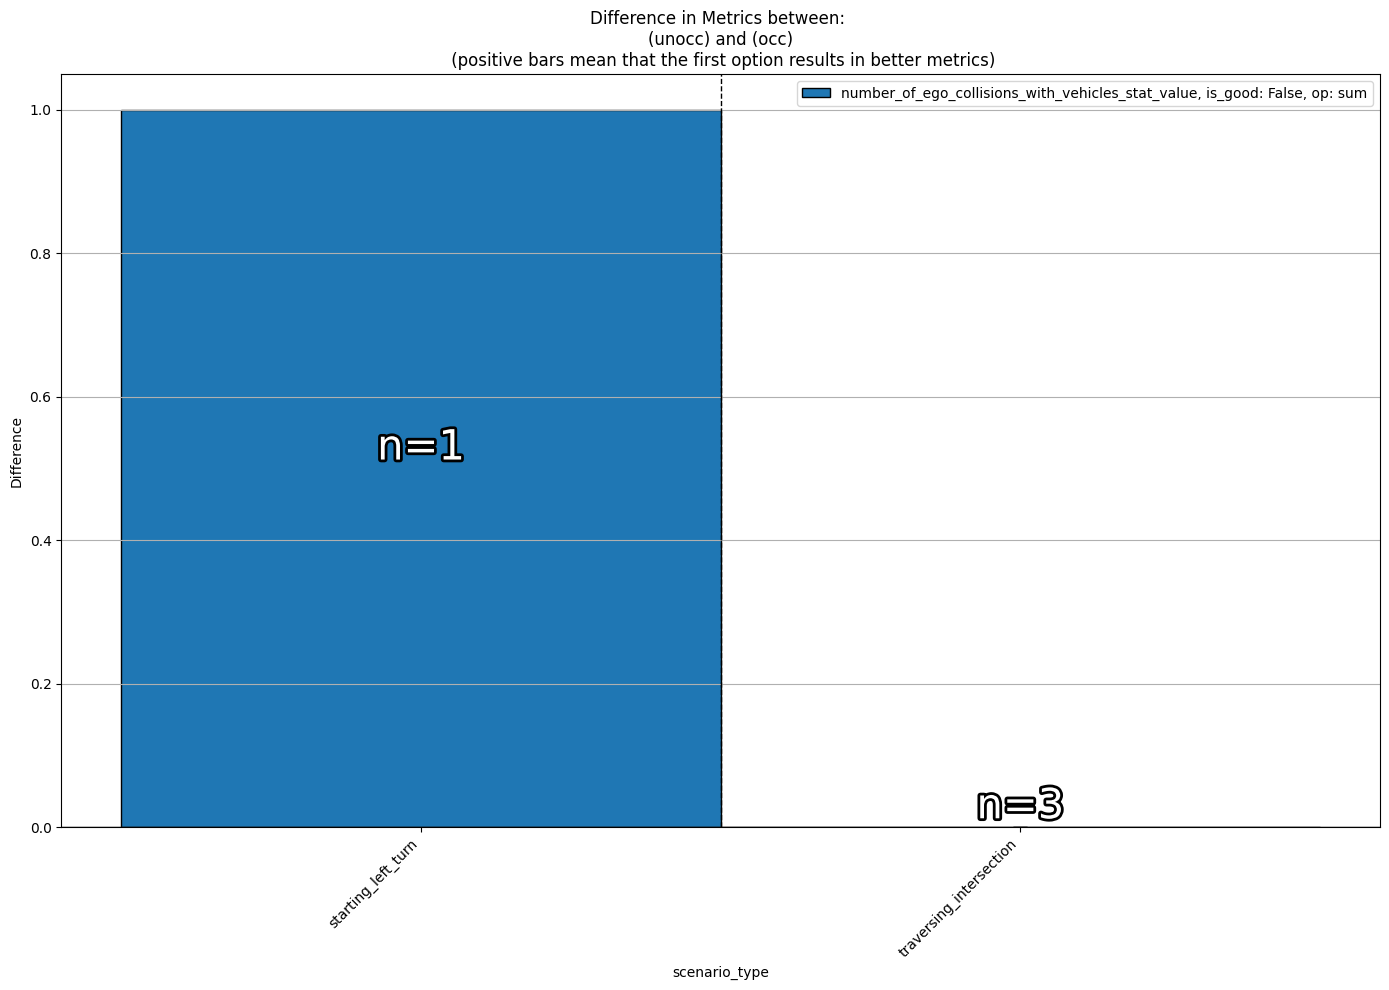

In [ ]:
from vis_utils import plot_diff

# %env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
# %env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
# %env NUPLAN_EXP_ROOT=../../data/nuplan/exp
# %env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
# %pwd

# output_folder_occ = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.24.05.29.17"
# )
# output_folder_unocc = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.24.05.36.28"
# )

file_path_1 = output_folder_unocc + "/metrics/" + "no_ego_at_fault_collisions.parquet"
file_path_2 = output_folder_occ + "/metrics/" + "no_ego_at_fault_collisions.parquet"


metrics = [
    "number_of_ego_collisions_with_vehicles_stat_value",
]
metric_op = [
    "sum",
]
# metrics are 'good' if you would like to succeed at them. ex: amount of crashes is bad, amount of money is good
good_metric = [
    False,
]

plot_diff(
    file_path_1,
    file_path_2,
    "unocc",
    "occ",
    metrics,
    metric_op,
    good_metric,
    group_by="scenario_type",
    k_differences=25,
    as_bool=True,
)

## Prepare the nuBoard config

In [ ]:
# import hydra

# scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
# output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.06.45"
# output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.55.22"

output_folder = [output_folder_occ, output_folder_unocc]

# output_folder = [output_folder_occ]
print(output_folder_occ)
print(output_folder_unocc)

CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        f"scenario_builder={scenario_builder}",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={output_folder}",  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

/home/sacardoz/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.17.17.52.47
/home/sacardoz/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.17.18.04.43


## Launch nuBoard (open in new tab - recommended)


In [ ]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2024-05-17 18:06:03,394 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2024-05-17 18:06:03,411 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2024-05-17 18:06:03,412 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2024-05-17 18:06:03,412 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2024-05-17 18:06:03,412 INFO {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2024-05-17 18:06:03,413 WARNING {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

INFO:tornado.access:200 GET / (127.0.0.1) 368.11ms
INFO:tornado.access:200 GET /resource/spectre.min.css (127.0.0.1) 2.64ms
INFO:tornado.access:200 GET /resource/css/scenario.css (127.0.0.1) 0.30ms
INFO:tornado.access:200 GET /resource/css/histogram.css (127.0.0.1) 0.27ms
INFO:tornado.access:200 GET /resource/spectre-icons.min.css (127.0.0.1) 0.48ms
INFO:tornado.access:200 GET /resource/style.css (127.0.0.1) 0.60ms
INFO:tornado.access:200 GET /resource/spectre-exp.min.css (127.0.0.1) 0.30ms
INFO:tornado.access:200 GET /resource/css/overview.css (127.0.0.1) 0.27ms
INFO:tornado.access:200 GET /resource/css/cloud.css (127.0.0.1) 0.27ms
INFO:tornado.access:200 GET /resource/scripts/utils.js (127.0.0.1) 0.28ms
INFO:tornado.access:200 GET /resource/motional_logo.png (127.0.0.1) 0.40ms


2024-05-17 18:06:04,811 INFO {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre.min.css (127.0.0.1) 2.64ms
2024-05-17 18:06:04,857 INFO {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/css/scenario.css (127.0.0.1) 0.30ms
2024-05-17 18:06:04,897 INFO {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/css/histogram.css (127.0.0.1) 0.27ms
2024-05-17 18:06:04,898 INFO {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre-icons.min.css (127.0.0.1) 0.48ms
2024-05-17 18:06:04,899 INFO {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/style.css (127.0.0.1) 0.60ms
2024-05-17 18:06:04,913 INFO {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectr

INFO:tornado.access:101 GET /ws (127.0.0.1) 0.42ms


2024-05-17 18:06:05,114 WARNING {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/tornado/web.py:2344}  404 GET /favicon.ico (127.0.0.1) 0.23ms
2024-05-17 18:06:05,171 INFO {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.42ms
2024-05-17 18:06:05,171 INFO {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2024-05-17 18:06:05,171 INFO {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created


(raylet) [2024-05-17 18:06:08,497 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746638336; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:06:18,500 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746638336; capacity: 16125711347712. Object creation will fail if spilling is required.
Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 61.22it/s]


2024-05-17 18:06:20,324 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.9625 seconds.


(raylet) [2024-05-17 18:06:28,502 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746630144; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:06:38,504 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746621952; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:06:48,506 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746593280; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:06:58,508 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746593280; capac

2024-05-17 18:08:32,895 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:575}  Frame deferred: 0
2024-05-17 18:08:33,470 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:897}  Frame dropped 0


(raylet) [2024-05-17 18:08:38,537 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746404864; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-05-17 18:08:48,336 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:575}  Frame deferred: 0
2024-05-17 18:08:48,485 INFO {/home/sacardoz/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:897}  Frame dropped 0


(raylet) [2024-05-17 18:08:48,539 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746380288; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:08:58,541 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746368000; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:09:08,543 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746363904; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-05-17 18:09:15,834 INFO {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:306}  WebSocket connection closed: code=1001, reason=None
2024-05-17 18:09:15,835 WARNING {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:287}  Failed sending message as connection was closed
2024-05-17 18:09:15,835 WARNING {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:287}  Failed sending message as connection was closed
2024-05-17 18:09:15,835 WARNING {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:287}  Failed sending message as connection was closed
2024-05-17 18:09:15,835 WARNING {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:287}  Failed sending message as connection was closed
2024-05-17 18:09:15,835 WARNING {/home/sacardoz/miniconda3/envs/tuplan/lib/python3.9/site-packages/bokeh/serv

(raylet) [2024-05-17 18:09:18,545 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746363904; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:09:28,547 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746363904; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:09:38,549 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746355712; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:09:48,551 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746331136; capac

KeyboardInterrupt: 

(raylet) [2024-05-17 18:10:48,564 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746134528; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:10:58,566 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746122240; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:11:08,569 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746114048; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-17 18:11:18,571 E 1247414 1247426] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-17_18-04-46_879341_1243430 is over 95% full, available space: 650746114048; capac